# Twitter cluster analysis:

##### Max Goldston
##### - Initial release (version 1.0): 2019/08/05
##### - Functionality: Clustering tweets containing information on how users spoke about airlines in February 2015. This template can be used with any unlabelled text data. This same path could be followed to cluster any dataset with many rows containing text. The number of clusters need to be chosen.
##### - Further steps: use elbow method in order to get the optimal number of clusters.
##### - Dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [126]:
import re                                                       # regular expressions
import nltk                                                     # nlp library
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import itertools                                                # corpus creation
import collections                                              # word counter
import networkx                                                 # word frequency representation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mgold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mgold\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Importing the dataset
dataset = pd.read_csv('Tweets.csv', delimiter = ',', encoding="utf-8")
dataset.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [4]:
# Looking for frequency of different negative reasons.
dataset.groupby(["negativereason"]).negativereason.count()

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
Name: negativereason, dtype: int64

In [5]:
# Number of positive, negative and neutral
dataset.groupby(["airline_sentiment"]).airline_sentiment.count()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Looking for the number of sentences with specific keywords
counter = 0
for i in dataset.text:
    if (('sitting' in i or 'on the plane' in i or 'on plane' in i or 'in the plane' in i) 
    and ('hours' in i or 'hour' in i or 'delay' in i or 'information' in i or 'update' in i or 'time' in i)):
        counter = counter + 1
print("There's {} ({}%) queries related with asking about delays while on the plane".format(counter, round(float(counter)/len(dataset.text)*100, 3)))

There's 118 (0.806%) queries related with asking about delays while on the plane


In [7]:
counter = 0
for i in dataset.text:
    if ('connecting flight' in i):
        counter = counter + 1
print("There's {} ({}%) queries related with connecting flights".format(counter, round(float(counter)/len(dataset.text)*100, 3)))

There's 67 (0.458%) queries related with connecting flights


In [8]:
counter = 0
for i in dataset.text:
    if 'wifi' in i:
        counter = counter + 1
print("There's {} ({}%) queries related with wifi".format(counter, round(float(counter)/len(dataset.text)*100, 3)))

There's 90 (0.615%) queries related with wifi


## Word frequency

In [9]:
# Formatting tweets (replacing symbols, lowecase, splitting). No stemming (corpus is needed for word freq count).
corpus1 = []
for i in range(0, len(dataset)):
    tweet = dataset['text'][i]
    tweet = tweet.lower()
    tweet = tweet.replace(',', '').replace('.', '').replace('-', '').replace('!', '').replace(';', '')
    tweet = tweet.split()
    corpus1.append(tweet)

In [10]:
# Create counter
allWords = list(itertools.chain(*corpus1))

In [11]:
# Taking out stop words
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in allWords if not w in stop_words] 
filtered_sentence = [] 
for w in allWords: 
    if w not in stop_words: 
        filtered_sentence.append(w)

#### One word

In [12]:
# Counting most used words
counts_no_urls = collections.Counter(filtered_sentence)
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(50),
                             columns=['words', 'count'])

clean_tweets_no_urls.head(20)

,words,count
0,@united,3840
1,flight,3750
2,@usairways,2977
3,@americanair,2928
4,@southwestair,2432
5,@jetblue,2056
6,get,1332
7,thanks,1064
8,cancelled,1048
9,service,899


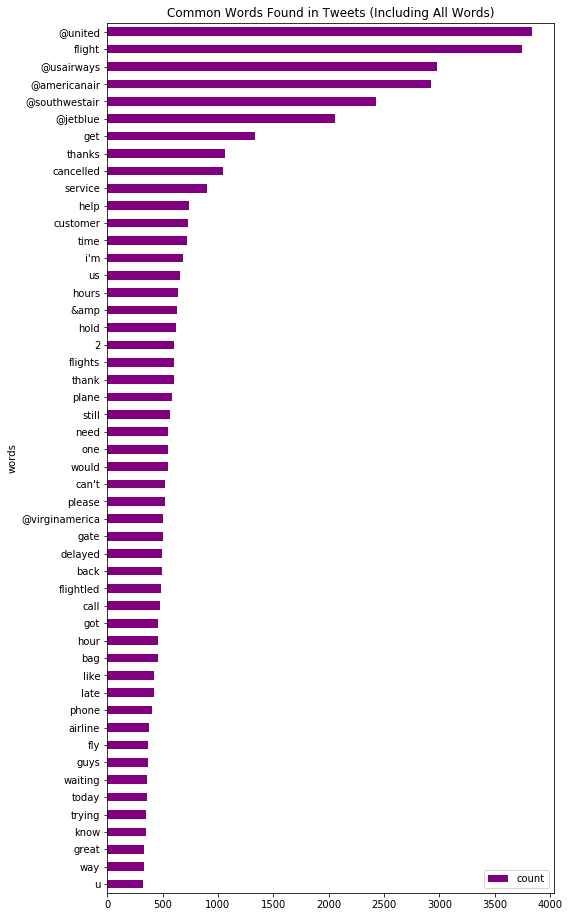

In [14]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 16))
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Tweets (Including All Words)")
plt.show()

#### Bigrams

In [15]:
bigramsList = list(nltk.bigrams(filtered_sentence))
countsBigrams = collections.Counter(bigramsList)
bigrams1 = pd.DataFrame(countsBigrams.most_common(50),columns=['words', 'count'])
bigrams1.head(20)

,words,count
0,"(customer, service)",518
1,"(cancelled, flightled)",477
2,"(late, flight)",230
3,"(cancelled, flighted)",206
4,"(flight, cancelled)",194
5,"(fleet's, fleek)",144
6,"(late, flightr)",141
7,"(cancelled, flight)",139
8,"(booking, problems)",138
9,"(@united, thanks)",131


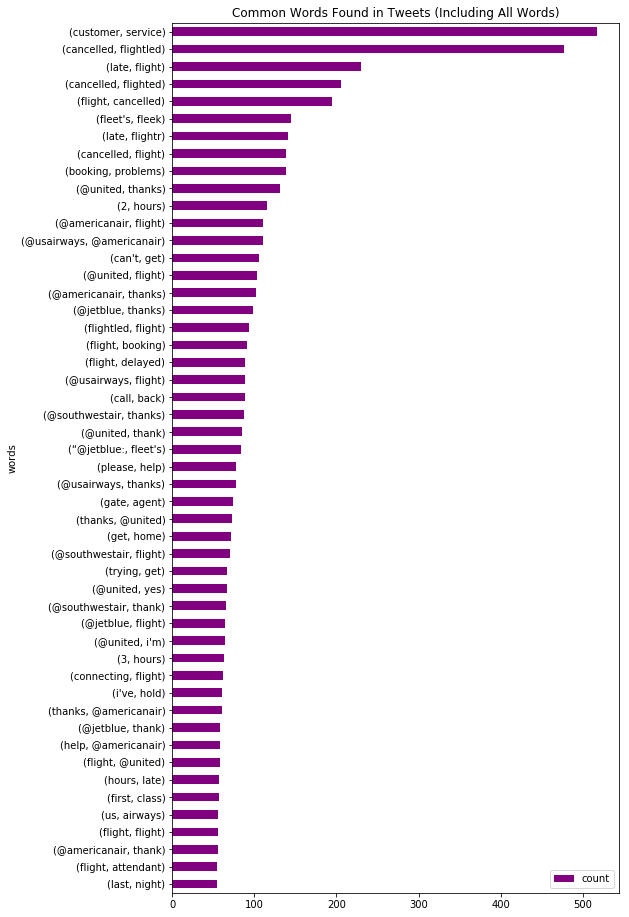

In [16]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 16))
bigrams1.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Tweets (Including All Words)")
plt.show()

#### Trigrams

In [17]:
trigramsList = list(nltk.trigrams(filtered_sentence))
countsTrigrams = collections.Counter(trigramsList)
countsTrigrams
trigrams1 = pd.DataFrame(countsTrigrams.most_common(50),
                             columns=['words', 'count'])
trigrams1.head(20)

,words,count
0,"(flight, cancelled, flightled)",122
1,"(cancelled, flightled, flight)",94
2,"(flight, booking, problems)",86
3,"(“@jetblue:, fleet's, fleek)",84
4,"(reflight, booking, problems)",47
5,"(flight, cancelled, flighted)",46
6,"(cancelled, flight, flight)",43
7,"(cancelled, flighted, flight)",41
8,"(@jetblue:, fleet's, fleek)",41
9,"(worst, customer, service)",40


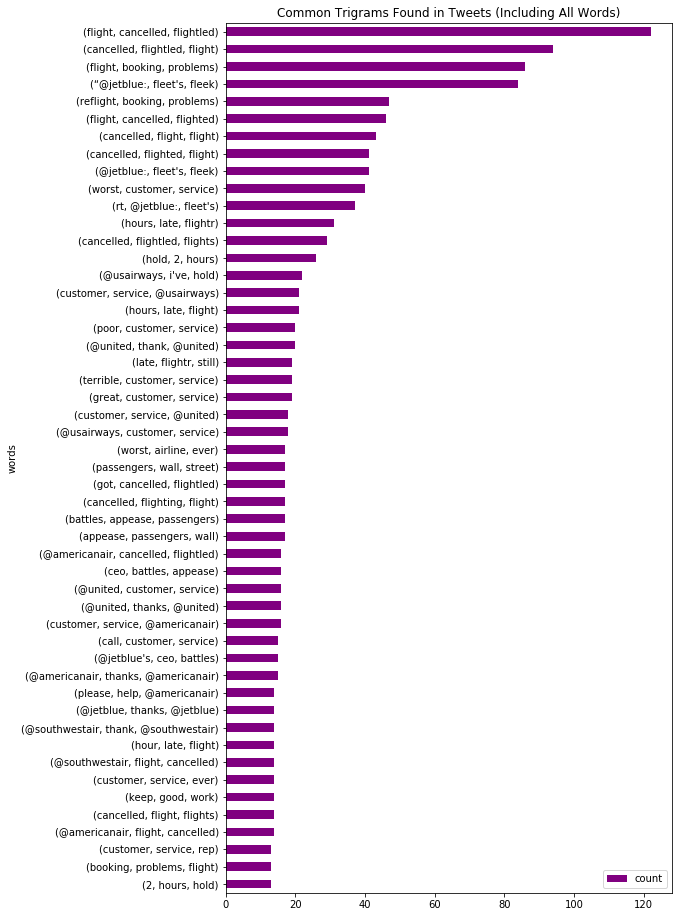

In [18]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 16))
trigrams1.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Trigrams Found in Tweets (Including All Words)")
plt.show()

## Cluster analysis (K-means)

In [19]:
# Filtering corpus, this time with stemmer (better for the cluster algorithm)
corpus = []
for i in range(0, len(dataset)):
    tweet = dataset['text'][i]
    tweet = tweet.lower()
    tweet = tweet.replace(',', '').replace('.', '').replace('-', '').replace('!', '').replace(';', '')
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]
    loopVar = []
    for i in tweet:
        if i not in stop_words:
            loopVar.append(i)
    loopVar = ' '.join(loopVar)
    corpus.append(loopVar)

In [20]:
# Creating Bag of Words for clustering
cv = CountVectorizer(max_features = 20000)
X = cv.fit_transform(corpus).toarray()

### Building model

In [21]:
true_k = 15 # set number of clusters as wished
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=15, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:  flight  usairway  delay  wa  hour  get  late  thank  miss  gate
Cluster 1:  custom  servic  unit  usairway  americanair  southwestair  thank  wa  flight  call
Cluster 2:  thank  southwestair  usairway  virginamerica  much  get  tco  http  wa  dm
Cluster 3:  worst  fli  pleas  you  americanair  delay  ever  repeat  credit  compani
Cluster 4:  flight  southwestair  wa  virginamerica  get  delay  thank  time  book  thi
Cluster 5:  us  usairway  unit  flight  get  plane  thi  airway  wa  hour
Cluster 6:  get  americanair  southwestair  flight  call  can  help  tri  back  need
Cluster 7:  usairway  thi  hold  hour  get  wa  call  time  wait  bag
Cluster 8:  jetblu  flight  thank  tco  http  wa  thi  delay  get  fli
Cluster 9:  americanair  flight  thank  thi  wa  call  hour  aa  tco  http
Cluster 10:  help  unit  usairway  need  southwestair  flight  pleas  get  wa  americanair
Cluster 11:  flight  cancel  unit  americanair  wa  late  get  delay  southwest

In [49]:
labels = model.predict(X)
labels

In [54]:
clusteredTweets = pd.DataFrame(dataset.text)
clusteredTweets["cluster"] = pd.DataFrame(labels)

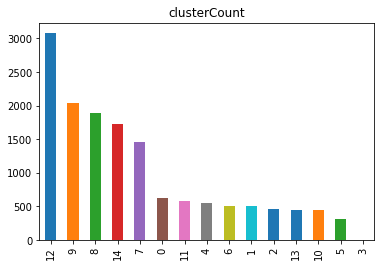

In [84]:
clusteredTweets.cluster.value_counts().plot(kind = 'bar', title = 'clusterCount')

In [104]:
# Getting the most representative tweet of each cluster
closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, X)

In [124]:
# Showing most representative tweet for each cluster and comparing to negative reason column
mostReprTweets = clusteredTweets.iloc[closest]
mostReprTweets["negativereason"] = dataset.negativereason[closest]
mostReprTweets

,text,cluster,negativereason
9392,@USAirways too Late Flight.,0,Can't Tell
4188,@united customer service 👎,1,Customer Service Issue
4447,@SouthwestAir Thank you!,2,NaN
11960,@AmericanAir worst company ever please do not ...,3,Late Flight
6532,@SouthwestAir too Late Flight now,4,Can't Tell
10697,@USAirways me too!,7,NaN
14439,@AmericanAir so how do we get me a person?,6,NaN
10697,@USAirways me too!,7,NaN
6897,@JetBlue or she ;),8,NaN
11905,@AmericanAir I did,9,NaN


In [ ]:
# Takes very long, only use it if you have a couple of hourse. I never ran it all.
distortions = []
K = range(20,22)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])